# Trying Again February

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.ion()
import matplotlib 

import os
from openai import OpenAI

import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt

## Mapping

In [2]:
# Goal: based on observation history and map with longer location history, repeatedly tell me what to do to get closer to the goal. 

# Need orientation drawn on map I think.... otherwise will be wonky 
def convert_angle_compass_to_cartesian(compass):
    return(((360 - compass) % 360) + 90) % 360

# OpenAI Setup
key = os.environ.get("OPENAI_API_KEY")
client = OpenAI(api_key = key)

# Mapping Setup
tiler = cimgt.OSM()
crs = tiler.crs

In [3]:
cur_pos = np.array([37.873550 , -122.267617])
campanile_pos = np.array([37.87210, -122.25780])

points = np.vstack([cur_pos, campanile_pos])
min_lat, min_long = np.min(points, axis = 0)
max_lat, max_long = np.max(points, axis = 0)

border = 0.001
bounds = [[min_lat - border, min_long - border],
          [max_lat + border, max_long + border]]

marker_size = 10

[1]
[1]
[1]
[1]


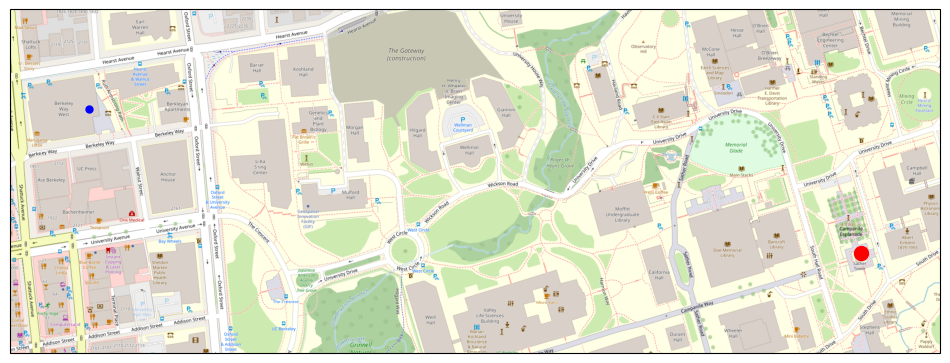

In [11]:
# Generate map
goal_point = campanile_pos

fig, ax = plt.subplots(
        figsize=(12, 10),
        subplot_kw={"projection": crs}
    )
print(plt.get_fignums())

ax.set_extent([bounds[0][1], bounds[1][1] , 
            bounds[0][0], bounds[1][0]], 
            crs=ccrs.PlateCarree())

print(plt.get_fignums())
# Add OpenStreetMap tiles
ax.add_image(tiler, 18)  # Zoom level (lower values = less zoomed-in)

print(plt.get_fignums())
ax.plot(
        goal_point[1], goal_point[0],
        marker="o", color="red", markersize=marker_size,
        transform=ccrs.PlateCarree()
    )


plt.savefig("./duh.png", dpi=300, bbox_inches='tight')
print(plt.get_fignums())

ax.plot(
        cur_pos[1], cur_pos[0],
        marker="o", color="green", markersize=marker_size,
        transform=ccrs.PlateCarree()
    )

plt.savefig("./nope.png", dpi=300, bbox_inches="tight")

# remove last point 

for artist in reversed(ax.get_children()):
    if isinstance(artist, matplotlib.lines.Line2D) and artist.get_marker() == "o":
        artist.set_color("blue")  # Change latest to be a history point instead
        artist.set_markersize(5)
        break

plt.savefig("./later.png", dpi=300, bbox_inches="tight")

In [8]:
plt.get_fignums()

[]

In [15]:
ax.plot(
        cur_pos[1], cur_pos[0],
        marker="o", color="red", markersize=marker_size,
        transform=ccrs.PlateCarree()
    )

In [7]:
plt.show()

In [8]:
plt.get_fignums()

[]

In [6]:
ax.show()

AttributeError: 'GeoAxes' object has no attribute 'show'

In [18]:
plt.show()

In [8]:
def generate_map(bounds, goal_point, marker_size = 10):
    """
    Bounds: [[min latitude, min longitude], [max latitude, max longitude]]
    Goal point: [latitude, longitude]
    """
    fig, ax = plt.subplots(
        figsize=(12, 10),
        subplot_kw={"projection": crs}
    )

    ax.set_extent([bounds[0][1], bounds[1][1] , 
                bounds[0][0], bounds[1][0]], 
                crs=ccrs.PlateCarree())

    # Add OpenStreetMap tiles
    ax.add_image(tiler, 18)  # Zoom level (lower values = less zoomed-in)

    ax.plot(
            goal_point[1], goal_point[0],
            marker="o", color="red", markersize=marker_size,
            transform=ccrs.PlateCarree()
        )

    # plt.savefig(save_loc, dpi=300, bbox_inches='tight')
    # if show:

    # plt.show()
    return fig, ax


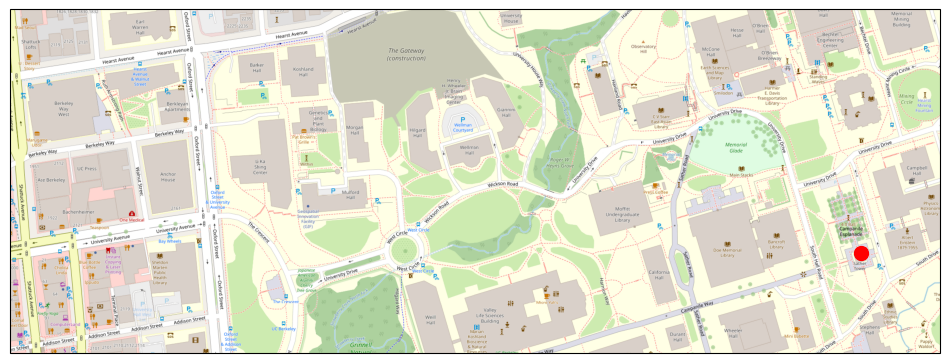

In [9]:
fig, ax = generate_map(bounds, campanile_pos)

In [6]:
plt.get_fignums()

[]

In [7]:
fig.show()

/tmp/ipykernel_2426580/89474557.py:1: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


In [21]:
# Remove Last Point 
def remove_last_point(fig, ax):

    for artist in reversed(ax.get_children()):
        if isinstance(artist, matplotlib.lines.Line2D) and artist.get_marker() == "o":
            artist.remove()  # Remove the last plotted marker
            break
    return fig, ax

In [24]:
fig, ax = remove_last_point(fig, ax)

In [25]:
plt.show()

In [26]:
fig.canvas.draw()

In [20]:
ax.get_children()

 Text(0.5, 1.0, ''),
 Text(0.0, 1.0, ''),
 Text(1.0, 1.0, ''),

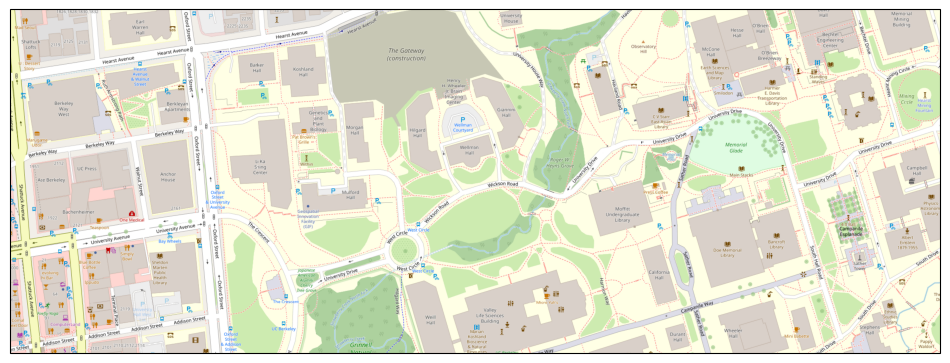

In [16]:
fig, ax = plt.subplots(
    figsize=(12, 10),
    subplot_kw={"projection": crs}
)

ax.set_extent([min_long - border, max_long + border , 
               min_lat -border , max_lat + border], 
               crs=ccrs.PlateCarree())

# Add OpenStreetMap tiles
ax.add_image(tiler, 18)  # Zoom level (lower values = less zoomed-in)

# # Plot points
# for lat, lon in other_options:
#     ax.plot(
#         lon, lat,
#         marker="o", color="purple", markersize=marker_size,
#         transform=ccrs.PlateCarree()
#     )

# ax.plot(
#         pos_history[-1][1], pos_history[-1][0],
#         marker="o", color="green", markersize=marker_size,
#         transform=ccrs.PlateCarree()
#     )

# ax.plot(
#         goal_pos[1], goal_pos[0],
#         marker="o", color="red", markersize=marker_size,
#         transform=ccrs.PlateCarree()
#     )

# plt.savefig(save_loc, dpi=300, bbox_inches='tight')
# if show:

plt.show()

In [7]:
# Generate Map


def generate_map(pos_history, goal_pos, border, text_offset, marker_size, save_loc, show = False):
    positions = np.vstack([pos_history, goal_pos])
    min_lat, min_long = np.min(positions, axis = 0)
    max_lat, max_long = np.max(positions, axis = 0)
    
    fig, ax = plt.subplots(
        figsize=(12, 10),
        subplot_kw={"projection": crs}
    )

    ax.set_extent([min_long - border, max_long + border , 
                 min_lat -border , max_lat + border], 
                crs=ccrs.PlateCarree())

    # Add OpenStreetMap tiles
    ax.add_image(tiler, 18)  # Zoom level (lower values = less zoomed-in)

    # Plot points
    for lat, lon in other_options:
        ax.plot(
            lon, lat,
            marker="o", color="purple", markersize=marker_size,
            transform=ccrs.PlateCarree()
        )

    ax.plot(
            pos_history[-1][1], pos_history[-1][0],
            marker="o", color="green", markersize=marker_size,
            transform=ccrs.PlateCarree()
        )

    ax.plot(
            goal_pos[1], goal_pos[0],
            marker="o", color="red", markersize=marker_size,
            transform=ccrs.PlateCarree()
        )

    plt.savefig(save_loc, dpi=300, bbox_inches='tight')
    if show:
        plt.show()

    plt.clf()

# Path Planning

In [10]:
import os
import base64
import matplotlib.pyplot as plt
from matplotlib import cm
import openai 
from openai import OpenAI
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
import numpy as np
from agentlace.action import ActionClient
import utils
import time
import re

import logging

# Suppress debug logs for PIL and matplotlib
logging.getLogger("PIL").setLevel(logging.INFO)
logging.getLogger("matplotlib").setLevel(logging.WARNING)
logging.getLogger('httpcore').setLevel(logging.WARNING)
logging.getLogger('httpx').setLevel(logging.WARNING)

# OpenAI Setup
key = os.environ.get("OPENAI_API_KEY")
client = OpenAI(api_key = key)

# Mapping Setup
tiler = cimgt.OSM()
crs = tiler.crs


goal_dist = 12 
planning_prompt = f"""
I am a wheeled robot, and you want to help me navigate to my desired goal position. 

I am able to take actions of the format (x, theta) where x represents my linear velocity, and theta represents my angular velocity. Both of these can be in the range (-1, 1), where -1 is going backwards for x, or to the right for theta. Sending one action usually makes me move by up to one foot in a given direction.
Sometimes, I stop being able to make progress on my path. 

I am giving you a birds eye view map of my environment. On the map, 
My current position is specified with a green dot, labelled C. 
My desired goal position is specified with a red dot, labelled G.
For context, C and G are {goal_dist} meters apart. 

It is easier to navigate to a closer goal first, on the way to G. The other goals I can go towards on my way to G are specified with purple dots, numbered 0-7. 
Try to stay close to dotted paths and sidewalks when possible, as well as trying to go as straight as possible when obstacles such as buildings are not in the way. 

Please respond to this message in the following format:
"Suggested intermediate goal: [Pick an index of the purple dot which seems most appropriate];
Reason for intermediate goal: [Explanation of why the chosen index is a good approach]"
"""

def test_points_eight(pos, offset):
    offsets = [[-1 * offset, -1 * offset], [-1 * offset, 0], [-1 * offset, offset],
            [0, -1 * offset],  [0, offset],
            [offset, -1 * offset], [offset, 0], [offset, offset]]
    
    return np.array([pos + np.array([i, j]) for i, j in offsets])

In [ ]:
cur_pos = np.array([37.873550 , -122.267617])
campanile_pos = np.array([37.87210, -122.25780])
goal_pos = campanile_pos
positions = np.vstack([cur_pos, goal_pos])

min_lat, min_long = np.min(positions, axis = 0)
max_lat, max_long = np.max(positions, axis = 0)
test_offset = max(max_lat - min_lat, max_long - min_long) / 8
other_options  = test_points_eight(goal_pos, test_offset)

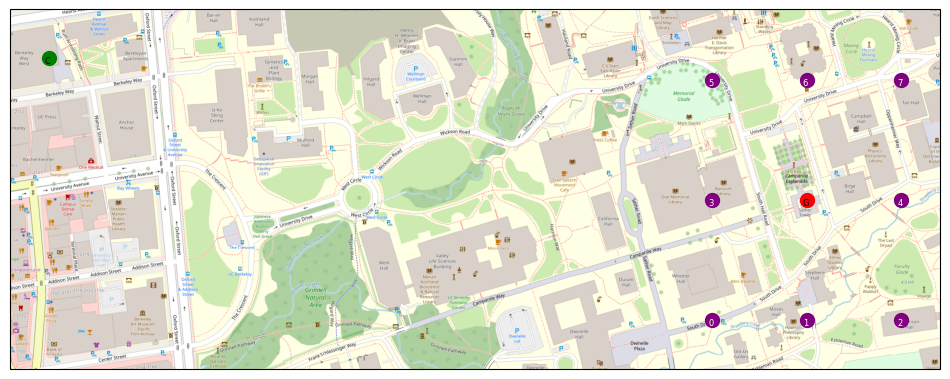

<Figure size 640x480 with 0 Axes>

In [16]:
border = 0.0005
marker_size = 10
text_offset = 0.00005


positions = np.vstack([cur_pos, goal_pos, other_options])
min_lat, min_long = np.min(positions, axis = 0)
max_lat, max_long = np.max(positions, axis = 0)

fig, ax = plt.subplots(
    figsize=(12, 10),
    subplot_kw={"projection": crs}
)

ax.set_extent([min_long - border, max_long + border , 
            min_lat -border , max_lat + border], 
            crs=ccrs.PlateCarree())

# Add OpenStreetMap tiles
ax.add_image(tiler, 18)  # Zoom level (lower values = less zoomed-in)

# Plot points
for lat, lon in other_options:
    ax.plot(
        lon, lat,
        marker="o", color="purple", markersize=marker_size,
        transform=ccrs.PlateCarree()
    )

ax.plot(
        cur_pos[1], cur_pos[0],
        marker="o", color="green", markersize=marker_size,
        transform=ccrs.PlateCarree()
    )

ax.plot(
        goal_pos[1], goal_pos[0],
        marker="o", color="red", markersize=marker_size,
        transform=ccrs.PlateCarree()
    )

# Add point labels
ax.text(cur_pos[1] - text_offset, cur_pos[0] - text_offset, 'C', transform=ccrs.PlateCarree(), fontsize=6, color="Black")
ax.text(goal_pos[1] - text_offset, goal_pos[0] - text_offset, 'G', transform=ccrs.PlateCarree(), fontsize=6, color="Black")
for idx, (lat, lon) in enumerate(other_options):
    ax.text(lon - text_offset , lat - text_offset, f'{idx}', transform=ccrs.PlateCarree(), fontsize=6, color="White")

# plt.savefig(save_loc, dpi=300, bbox_inches='tight')
plt.show()
plt.clf()

In [ ]:
positions = np.vstack([cur_pos, goal_pos, other_options])
min_lat, min_long = np.min(positions, axis = 0)
max_lat, max_long = np.max(positions, axis = 0)

fig, ax = plt.subplots(
    figsize=(12, 10),
    subplot_kw={"projection": crs}
)

ax.set_extent([min_long - border, max_long + border , 
            min_lat -border , max_lat + border], 
            crs=ccrs.PlateCarree())

# Add OpenStreetMap tiles
ax.add_image(tiler, 18)  # Zoom level (lower values = less zoomed-in)

# Plot points
for lat, lon in other_options:
    ax.plot(
        lon, lat,
        marker="o", color="purple", markersize=marker_size,
        transform=ccrs.PlateCarree()
    )

ax.plot(
        cur_pos[1], cur_pos[0],
        marker="o", color="green", markersize=marker_size,
        transform=ccrs.PlateCarree()
    )

ax.plot(
        goal_pos[1], goal_pos[0],
        marker="o", color="red", markersize=marker_size,
        transform=ccrs.PlateCarree()
    )

# Add point labels
ax.text(cur_pos[1] - text_offset, cur_pos[0] - text_offset, 'C', transform=ccrs.PlateCarree(), fontsize=6, color="Black")
ax.text(goal_pos[1] - text_offset, goal_pos[0] - text_offset, 'G', transform=ccrs.PlateCarree(), fontsize=6, color="Black")
for idx, (lat, lon) in enumerate(other_options):
    ax.text(lon - text_offset , lat - text_offset, f'{idx}', transform=ccrs.PlateCarree(), fontsize=6, color="White")

plt.savefig(save_loc, dpi=300, bbox_inches='tight')
if show:
    plt.show()

plt.clf()



In [8]:
cur_pos = np.array([37.873550 , -122.267617])
campanile_pos = np.array([37.87210, -122.25780])
goal_pos = campanile_pos

In [ ]:
cur_pos = np.array([37.873550 , -122.267617])
campanile_pos = np.array([37.87210, -122.25780])
goal_pos = campanile_pos  
# goal_pos = np.array([37.873289 , -122.267378])
goals_list = generate_intermediate_goals(cur_pos, goal_pos, threshold = 0.005)

In [ ]:
cur_pos = np.array([37.873550 , -122.267617])
campanile_pos = np.array([37.87210, -122.25780])
goal_pos = campanile_pos  
# goal_pos = np.array([37.873289 , -122.267378])
goals_list = generate_intermediate_goals(cur_pos, goal_pos, threshold = 0.005)

# Whole System

In [5]:
import os
import base64
import matplotlib.pyplot as plt
from matplotlib import cm
import openai 
from openai import OpenAI
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
import numpy as np
from agentlace.action import ActionClient
import utils
import time
import re

import logging

# Suppress debug logs for PIL and matplotlib
logging.getLogger("PIL").setLevel(logging.INFO)
logging.getLogger("matplotlib").setLevel(logging.WARNING)
logging.getLogger('httpcore').setLevel(logging.WARNING)
logging.getLogger('httpx').setLevel(logging.WARNING)

# OpenAI Setup
key = os.environ.get("OPENAI_API_KEY")
client = OpenAI(api_key = key)

# FrodoBot Setup
# action_client = ActionClient(
#             server_ip="localhost",
#             config=utils.make_action_config("frodobot")
#         )

# Mapping Setup
tiler = cimgt.OSM()
crs = tiler.crs

def test_points_eight(pos, offset):
    offsets = [[-1 * offset, -1 * offset], [-1 * offset, 0], [-1 * offset, offset],
            [0, -1 * offset],  [0, offset],
            [offset, -1 * offset], [offset, 0], [offset, offset]]
    
    return np.array([pos + np.array([i, j]) for i, j in offsets])

def generate_map(cur_pos, goal_pos, other_options, border, text_offset, marker_size, save_loc, show = False):
    positions = np.vstack([cur_pos, goal_pos, other_options])
    min_lat, min_long = np.min(positions, axis = 0)
    max_lat, max_long = np.max(positions, axis = 0)
    
    fig, ax = plt.subplots(
        figsize=(12, 10),
        subplot_kw={"projection": crs}
    )

    ax.set_extent([min_long - border, max_long + border , 
                min_lat -border , max_lat + border], 
                crs=ccrs.PlateCarree())

    # Add OpenStreetMap tiles
    ax.add_image(tiler, 18)  # Zoom level (lower values = less zoomed-in)

    # Plot points
    for lat, lon in other_options:
        ax.plot(
            lon, lat,
            marker="o", color="purple", markersize=marker_size,
            transform=ccrs.PlateCarree()
        )

    ax.plot(
            cur_pos[1], cur_pos[0],
            marker="o", color="green", markersize=marker_size,
            transform=ccrs.PlateCarree()
        )

    ax.plot(
            goal_pos[1], goal_pos[0],
            marker="o", color="red", markersize=marker_size,
            transform=ccrs.PlateCarree()
        )

    # Add point labels
    ax.text(cur_pos[1] - text_offset, cur_pos[0] - text_offset, 'C', transform=ccrs.PlateCarree(), fontsize=6, color="Black")
    ax.text(goal_pos[1] - text_offset, goal_pos[0] - text_offset, 'G', transform=ccrs.PlateCarree(), fontsize=6, color="Black")
    for idx, (lat, lon) in enumerate(other_options):
        ax.text(lon - text_offset , lat - text_offset, f'{idx}', transform=ccrs.PlateCarree(), fontsize=6, color="White")

    plt.savefig(save_loc, dpi=300, bbox_inches='tight')
    if show:
        plt.show()

    plt.clf()

def generate_rainbow_map(points, border, text_offset, marker_size, show=False):
    # Convert list of points to a numpy array for easier manipulation
    points_array = np.array(points)
    min_lat, min_long = np.min(points_array, axis=0)
    max_lat, max_long = np.max(points_array, axis=0)

    # Set up the map projection and figure
    fig, ax = plt.subplots(
        figsize=(12, 10),
        subplot_kw={"projection": ccrs.PlateCarree()}
    )

    ax.set_extent([min_long - border, max_long + border, 
                   min_lat - border, max_lat + border], 
                   crs=ccrs.PlateCarree())

    # Add OpenStreetMap tiles
    tiler = cimgt.OSM()
    ax.add_image(tiler, 18)  # Zoom level

    # Color map 
    color_map = cm.viridis  
    
    # Normalize the points index to map them to the color map
    num_points = len(points)
    norm = plt.Normalize(vmin=0, vmax=num_points - 1)

    # Plot each point with corresponding color
    for idx, (lat, lon) in enumerate(points):
        color = color_map(norm(idx))  # Get the color based on the index
        ax.plot(lon, lat, marker="o", color=color, markersize=marker_size, transform=ccrs.PlateCarree())
        
    plt.show()

correction_to_action = { # linear, angular, frequency
    "back0": [(-1., 0., 3)],
    "back45left": [(-1., 0., 1), (-1., -1., 1)],
    "back45right": [(-1., 0., 1), (-1., 1., 1)],
    "back90left": [(-1., 0., 1), (-0.5, -1., 3)],
    "back90right": [(-1., 0., 1), (-0.5, 1., 3)],
    "back180": [(-1., 0., 1), [0.5, 1., 6]],
    "front45left": [(1., 0., 1), (1., 1., 1)],
    "front45right": [(1., 0., 1), (1., -1., 1)],
    "front90left": [(1., 0., 1), (0.5, 1., 3)],
    "front90right": [(1., 0., 1), (0.5, -1., 3)],
    "front180": [(1., 0., 1), (0.5, -1., 6)],
    "back180": [(-1., 0., 1), (0.5, -1., 6)],
}

corrections_idx = [
    "back0",
    "back45left",
    "back45right",
    "back90left",
    "back90right",
    "back180",
    "front45left",
    "front45right",
    "front90left",
    "front90right", 
    "front180",
    "back180",
]

def make_correction(idx):
    correction = corrections_idx[idx]
    actions = correction_to_action[correction]

    for lin, ang, freq in actions:
        for _ in range(freq):
            action_client.act("action_vw", np.array([lin, ang]))
            time.sleep(0.2)

def encode_image_to_base64(image_path):
    with open(image_path, "rb") as image_file:
        img_b64_bytes = base64.b64encode(image_file.read())
        img_b64_str = img_b64_bytes.decode("utf-8")
    return img_b64_str

planning_prompt = f"""
I am a wheeled robot, and you want to help me navigate to my desired goal position. 

I am able to take actions of the format (x, theta) where x represents my linear velocity, and theta represents my angular velocity. Both of these can be in the range (-1, 1), where -1 is going backwards for x, or to the right for theta. Sending one action usually makes me move by up to one foot in a given direction.
Sometimes, I stop being able to make progress on my path. 

I am giving you a birds eye view map of my environment. 
My current position is specified with a green dot, labelled C. 
My desired goal position is specified with a red dot, labelled G.
The other goals I can go towards on my way to G are specified with purple dots, numbered 0-7. 

I want to make my life easier and get to one of the alterative goals before continuing on to the final goal. 
Try to stay close to dotted paths and roads when possible, as well as generally trying to go as straight as possible when obstacles such as buildings are not in the way. 

Please respond to this message in the following format:
"Suggested intermediate goal: [Pick an index of the purple dot which seems most appropriate];
Reason for intermediate goal: [Explanation of why the chosen index is a good approach]"
"""

help_prompt = f"""
I am a wheeled robot, and you want to help me navigate to my desired goal position. 

I am able to take actions of the format (x, theta) where x represents my linear velocity, and theta represents my angular velocity. Both of these can be in the range (-1, 1), where -1 is going backwards for x, or to the right for theta. Sending one action usually makes me move by up to one foot in a given direction.
Sometimes, I stop being able to make progress on my path. 

I am giving you a birds eye view map of my environment, as well as my point of view both in front of me and behind me.

My current position is specified with a green dot, labelled C. 
My desired goal position is specified with a red dot, labelled G.
I have stopped being able to make progress towards my desired goal. 

My options for interventions to get back on track are:
0. Back straight up
1. Back up and turn 45 degrees to the right
2. Back up and turn 45 degrees to the left
3. Back up and turn 90 degrees to the right
4. Back up and turn 90 degrees to the left
5. Back up and turn 180 degrees
6. Move forward and turn 45 degrees to the right
7. Move forward and turn 45 degrees to the left
8. Move forward and turn 90 degrees to the right
9. Move forward and turn 90 degrees to the left
10. Move forward and turn 180 degrees
11. Move backward and turn 180 degrees

In the absolute worst case, I can call for human intervention, which you can reference with index 12, but this should be reserved for extreme cases.

Please respond to this message in the following format:
"Suggested intervention: [Pick the index of the most appropriate intervention];
Reason for intervention: [Explanation of why the chosen index is a good approach]"
"""

def generate_intermediate_goals(cur_pos, goal_pos, threshold):
        
    goals = [goal_pos] 

    i = 0
    while np.linalg.norm(goals[-1]) > threshold and i < 6:
        goal_pos = goals[-1]
        positions = np.vstack([cur_pos, goal_pos])
        min_lat, min_long = np.min(positions, axis = 0)
        max_lat, max_long = np.max(positions, axis = 0)
        test_offset = max(max_lat - min_lat, max_long - min_long) / 5
        other_options  = test_points_eight(goal_pos, test_offset)

        border = 0.0005
        marker_size = 10
        text_offset = 0.00005
        save_loc = f"step_{i}.png"

        generate_map(cur_pos, goal_pos, other_options, border, text_offset, marker_size, save_loc, show = False)

        img_type_obs = "image/png"
        img_b64_str_map = encode_image_to_base64(save_loc)

        response = client.chat.completions.create(
            model="gpt-4o-mini",
            messages=[
                {
                    "role": "user",
                    "content": [
                        {"type": "text", "text": planning_prompt},
                        {
                            "type": "image_url",
                            "image_url": {"url": f"data:{img_type_obs};base64,{img_b64_str_map}"},
                        },
                    ],
                }
            ],
            max_tokens = 1000,
        )

        # print(response.choices[0].message.content)
        arr_3_resp = response.choices[0].message.content.split("\n")

        choice = re.search(r'.*Suggested intermediate goal:.* (\d+);?\s*', arr_3_resp[0])

        if choice:
            last_number = choice.group(1)
        else:
            print("No number found")
            
        chosen_idx = int(last_number)
        goals.append(other_options[chosen_idx])

        i += 1

    return goals

def choose_correction(cur_pos, goal_pos):
    positions = np.vstack([cur_pos, goal_pos])
    min_lat, min_long = np.min(positions, axis = 0)
    max_lat, max_long = np.max(positions, axis = 0)

    border = 0.0005
    marker_size = 10
    text_offset = 0.00005
    save_loc = f"trash.png"

    generate_map(cur_pos, goal_pos, np.array([cur_pos, cur_pos]), border, text_offset, marker_size, save_loc, show = False)

    img_type_obs = "image/png"
    img_b64_str_map = encode_image_to_base64(save_loc)

    # # Current Observation
    obs = action_client.obs()
    img_type_obs = "image/jpeg"
    img_b64_str_obs_front = obs["front_frame"]
    img_b64_str_obs_rear = obs["rear_frame"]

    response = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": help_prompt},
                    {
                        "type": "image_url",
                        "image_url": {"url": f"data:{img_type_obs};base64,{img_b64_str_map}"},
                    },
                    {
                        "type": "image_url",
                        "image_url": {"url": f"data:{img_type_obs};base64,{img_b64_str_obs_front}"},
                    },
                    {
                        "type": "image_url",
                        "image_url": {"url": f"data:{img_type_obs};base64,{img_b64_str_obs_rear}"},
                    },
                ],
            }
        ],
        max_tokens = 1000,
    )

    print(response.choices[0].message.content)
    arr_3_resp = response.choices[0].message.content.split("\n")

    choice = re.search(r'.*Suggested intervention:.* (\d+);?\s*', arr_3_resp[0])

    if choice:
        last_number = choice.group(1)
    else:
        print("No number found")
        
    chosen_idx = int(last_number)
    return chosen_idx

In [11]:
def generate_intermediate_goals(cur_pos, goal_pos, threshold):
        
    goals = [goal_pos] 

    i = 0
    while np.linalg.norm(goals[-1]) > threshold and i < 6:
        goal_pos = goals[-1]
        positions = np.vstack([cur_pos, goal_pos])
        min_lat, min_long = np.min(positions, axis = 0)
        max_lat, max_long = np.max(positions, axis = 0)
        test_offset = max(max_lat - min_lat, max_long - min_long) / 5
        other_options  = test_points_eight(goal_pos, test_offset)

        border = 0.0005
        marker_size = 10
        text_offset = 0.00005
        save_loc = f"step_{i}.png"

        generate_map(cur_pos, goal_pos, other_options, border, text_offset, marker_size, save_loc, show = False)

        img_type_obs = "image/png"
        img_b64_str_map = encode_image_to_base64(save_loc)

        response = client.chat.completions.create(
            model="gpt-4o-mini",
            messages=[
                {
                    "role": "user",
                    "content": [
                        {"type": "text", "text": planning_prompt},
                        {
                            "type": "image_url",
                            "image_url": {"url": f"data:{img_type_obs};base64,{img_b64_str_map}"},
                        },
                    ],
                }
            ],
            max_tokens = 1000,
        )

        # print(response.choices[0].message.content)
        arr_3_resp = response.choices[0].message.content.split("\n")

        choice = re.search(r'.*Suggested intermediate goal:.* (\d+);?\s*', arr_3_resp[0])

        if choice:
            last_number = choice.group(1)
        else:
            print("No number found")
            
        chosen_idx = int(last_number)
        goals.append(other_options[chosen_idx])

        i += 1

    return goals

In [ ]:
cur_pos = np.array([37.873550 , -122.267617])
campanile_pos = np.array([37.87210, -122.25780])
goal_pos = campanile_pos  
# goal_pos = np.array([37.873289 , -122.267378])
goals_list = generate_intermediate_goals(cur_pos, goal_pos, threshold = 0.005)

In [ ]:
# GENERATED PATH
goals_with_start = goals_list + [cur_pos]
border = 0.0005
marker_size = 10
text_offset = 0.00005

generate_rainbow_map(goals_with_start, border, text_offset, marker_size, True)

In [5]:
def choose_correction(cur_pos, goal_pos):
    positions = np.vstack([cur_pos, goal_pos])
    min_lat, min_long = np.min(positions, axis = 0)
    max_lat, max_long = np.max(positions, axis = 0)

    border = 0.0005
    marker_size = 10
    text_offset = 0.00005
    save_loc = f"trash.png"

    generate_map(cur_pos, goal_pos, np.array([cur_pos, cur_pos]), border, text_offset, marker_size, save_loc, show = False)

    img_type_obs = "image/png"
    img_b64_str_map = encode_image_to_base64(save_loc)

    # # Current Observation
    obs = action_client.obs()
    img_type_obs = "image/jpeg"
    img_b64_str_obs_front = obs["front_frame"]
    img_b64_str_obs_rear = obs["rear_frame"]

    response = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": help_prompt},
                    {
                        "type": "image_url",
                        "image_url": {"url": f"data:{img_type_obs};base64,{img_b64_str_map}"},
                    },
                    {
                        "type": "image_url",
                        "image_url": {"url": f"data:{img_type_obs};base64,{img_b64_str_obs_front}"},
                    },
                    {
                        "type": "image_url",
                        "image_url": {"url": f"data:{img_type_obs};base64,{img_b64_str_obs_rear}"},
                    },
                ],
            }
        ],
        max_tokens = 1000,
    )

    print(response.choices[0].message.content)
    arr_3_resp = response.choices[0].message.content.split("\n")

    choice = re.search(r'.*Suggested intervention:.* (\d+);?\s*', arr_3_resp[0])

    if choice:
        last_number = choice.group(1)
    else:
        print("No number found")
        
    chosen_idx = int(last_number)
    return chosen_idx
        



In [ ]:
cur_pos = np.array([37.873550 , -122.267617])
goal_pos = goals_list[-1]

c = choose_correction(cur_pos, goal_pos)
make_correction(c)

In [23]:
import time

In [35]:
make_correction(9)

In [ ]:
cur_pos = np.array([37.873550 , -122.267617])
campanile_pos = np.array([37.87210, -122.25780])
goal_pos = campanile_pos
# goal_pos = np.array([37.873289 , -122.267378])

goal_pos = goals_list[-1]
positions = np.vstack([cur_pos, goal_pos])
min_lat, min_long = np.min(positions, axis = 0)
max_lat, max_long = np.max(positions, axis = 0)

border = 0.0005
marker_size = 10
text_offset = 0.00005
save_loc = f"trash.png"

generate_map(cur_pos, goal_pos, np.array([cur_pos, cur_pos]), border, text_offset, marker_size, save_loc, show = False)

img_type_obs = "image/png"
img_b64_str_map = encode_image_to_base64(save_loc)

# # Current Observation
obs = action_client.obs()
img_type_obs = "image/jpeg"
img_b64_str_obs_front = obs["front_frame"]
img_b64_str_obs_rear = obs["rear_frame"]

response = client.chat.completions.create(
    model="gpt-4o-mini",
    messages=[
        {
            "role": "user",
            "content": [
                {"type": "text", "text": help_prompt},
                {
                    "type": "image_url",
                    "image_url": {"url": f"data:{img_type_obs};base64,{img_b64_str_map}"},
                },
                {
                    "type": "image_url",
                    "image_url": {"url": f"data:{img_type_obs};base64,{img_b64_str_obs_front}"},
                },
                {
                    "type": "image_url",
                    "image_url": {"url": f"data:{img_type_obs};base64,{img_b64_str_obs_rear}"},
                },
            ],
        }
    ],
    max_tokens = 1000,
)

print(response.choices[0].message.content)
arr_3_resp = response.choices[0].message.content.split("\n")

choice = re.search(r'.*Suggested intervention goal:.* (\d+);?\s*', arr_3_resp[0])

if choice:
    last_number = choice.group(1)
else:
    print("No number found")
    
chosen_idx = int(last_number)
# goals.append(other_options[chosen_idx])


In [ ]:
90 degrees = 
def correction_to_action(direction, angle):
    if angle = None:


options

linear = [-1, 1]
angular = []

# Putting it Together

In [ ]:
import os
import base64
import matplotlib.pyplot as plt
import openai 
from openai import OpenAI
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
import numpy as np
from agentlace.action import ActionClient
import utils

import logging

# Suppress debug logs for PIL and matplotlib
logging.getLogger("PIL").setLevel(logging.INFO)
logging.getLogger("matplotlib").setLevel(logging.WARNING)

# OpenAI Setup
key = os.environ.get("OPENAI_API_KEY")
client = OpenAI(api_key = key)

prompt = f"""I am a cute little robot, and you want to help me navigate to my desired goal position.
I am able to take actions of the format (x, theta) where x represents my linear velocity, and theta represents my angular velocity. Both of these can be in the range (-1, 1), where -1 is going backwards for x, or to the right for theta. Sending one action usually makes me move by up to one foot in a given direction.
Sometimes, I stop being able to make progress on my path. 
I also hate bumping into things and people. That might not be safe! I don't want to break or be rude.

I am giving you a picture showing what I can see from my front camera. 

Right now, I'm not making enough progress towards my goal, so I want to find a new goal on my way over.
I am also giving you a map of what is going on. 
My current position is specified with a green dot, labelled C. 
My desired goal position is specified with a red dot, labelled G.
The alterative goals I can go towards on my way to G are specified with purple dots, numbered 0-7. 

Please respond to this message in the following format:
"Reason for not making progress: [Explain why it seems like I'm not making progress towards the goal based on the map and observation.];
Suggested next goal: [Pick an index of the purple dot which seems most appropriate];
Reason for next goal: [Explanation of why the chosen index is a good approach]"
"""

# FrodoBot Setup
action_client = ActionClient(
            server_ip="localhost",
            config=utils.make_action_config("frodobot")
        )

# Mapping Setup
tiler = cimgt.OSM()
crs = tiler.crs
current_img = "test_img.png"

In [2]:
# HELPER FUNCTIONS
def test_points_eight(pos, offset):
    offsets = [[-1 * offset, -1 * offset], [-1 * offset, 0], [-1 * offset, offset],
            [0, -1 * offset],  [0, offset],
            [offset, -1 * offset], [offset, 0], [offset, offset]]
    
    return np.array([pos + np.array([i, j]) for i, j in offsets])

def generate_map(cur_pos, goal_pos, other_options, border, text_offset, save_loc):
    
    coords = np.vstack([other_options, cur_pos, goal_pos])

    # create the map 
    fig, ax = plt.subplots(
        figsize=(12, 10),
        subplot_kw={"projection": crs}
    )

    # find & set plotting bounds
    min_lat, min_long = np.min(coords, axis = 0)
    max_lat, max_long = np.max(coords, axis = 0)
    ax.set_extent([min_long - border, max_long + border, 
                min_lat - border/ 2, max_lat + border / 2], 
                crs=ccrs.PlateCarree())

    # Add OpenStreetMap tiles
    ax.add_image(tiler, 18)  # Zoom level (lower values = less zoomed-in)

    # Plot points
    ax.plot(
            cur_pos[1], cur_pos[0],
            marker="o", color="green", markersize=8,
            transform=ccrs.PlateCarree()
        )

    ax.plot(
            goal_pos[1], goal_pos[0],
            marker="o", color="red", markersize=8,
            transform=ccrs.PlateCarree()
        )

    for lat, lon in other_options:
        ax.plot(
            lon, lat,
            marker="o", color="purple", markersize=8,
            transform=ccrs.PlateCarree()
        )

    # Add point labels
    ax.text(cur_pos[1] - text_offset, cur_pos[0] - text_offset, 'C', transform=ccrs.PlateCarree(), fontsize=6, color="Black")
    ax.text(goal_pos[1] - text_offset, goal_pos[0] - text_offset, 'G', transform=ccrs.PlateCarree(), fontsize=6, color="Black")
    for idx, (lat, lon) in enumerate(other_options):
        ax.text(lon - text_offset , lat - text_offset, f'{idx}', transform=ccrs.PlateCarree(), fontsize=6, color="White")

    # Save  map
    plt.savefig(save_loc, dpi=300, bbox_inches='tight')

def encode_image_to_base64(image_path):
    with open(image_path, "rb") as image_file:
        img_b64_bytes = base64.b64encode(image_file.read())
        img_b64_str = img_b64_bytes.decode("utf-8")
    return img_b64_str



In [3]:
goals = [np.array([37.873289 , -122.267378]) ]
cur_pos = np.array([37.873550 , -122.267617])
test_offset = 0.00008

In [ ]:
# Map 
goal_pos = goals[0]
other_options = test_points_eight(goal_pos, test_offset)
generate_map(cur_pos, goal_pos, other_options, 0.0015, 0.000011, current_img)
img_type_obs = "image/png"
img_b64_str_map = encode_image_to_base64(current_img)

# Current Observation
obs = action_client.obs()
img_type_obs = "image/jpeg"
img_b64_str_obs = obs["front_frame"]


response = client.chat.completions.create(
    model="gpt-4o-mini",
    messages=[
        {
            "role": "user",
            "content": [
                {"type": "text", "text": prompt},
                {
                    "type": "image_url",
                    "image_url": {"url": f"data:{img_type_obs};base64,{img_b64_str_obs}"},
                },
                {
                    "type": "image_url",
                    "image_url": {"url": f"data:{img_type_obs};base64,{img_b64_str_map}"},
                },
            ],
        }
    ],
    max_tokens = 1000,
)

In [ ]:
print(response.choices[0].message.content)
arr_3_resp = response.choices[0].message.content.split("\n\n")
chosen_idx = int(arr_3_resp[1][-1])
goals.insert(0, other_options[chosen_idx])

In [ ]:
plt.imshow(utils.decode_from_base64(obs["front_frame"]))
plt.show()

In [ ]:
response = client.chat.completions.create(
    model="gpt-4o-mini",
    messages= [
    {
      "role": "system",
      "content": 
        [{
          "type": "text",
          "text": """
            You are a helpful assistant that answers programming questions 
            in the style of a southern belle from the southeast United States.
          """
        }]
      
    },
    {
      "role": "user",
      "content": 
        [{
          "type": "text",
          "text": "Are semicolons optional in JavaScript?"
        }]
      
    }
    ],
    max_tokens = 1000,
)

In [ ]:
print(response.choices[0].message.content)